# Statistical Analyses

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV


In [3]:
# Load DF
df = pd.read_csv('C:/Users/nickm/Desktop/Coding/Projects/marketing-analytics-data/ifood_df.csv')
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [4]:
df.insert(0, 'Income_1k', df['Income'] / 1000)
#df['Income_1k'] = df['Income'] / 1000
df.filter(like='Income').describe()


,Income_1k,Income
count,2205.000000,2205.000000
mean,51.622095,51622.094785
std,20.713064,20713.063826
min,1.730000,1730.000000
25%,35.196000,35196.000000
50%,51.287000,51287.000000
75%,68.281000,68281.000000
max,113.734000,113734.000000


## Linear Regression predicting Amounts Spent for each Category

We will perform regression analyses for each product category (MntX) individually and store the results in a single DataFrame.<br>
In order to ease interpretation, only the coefficients of the variables which are statistically significant will be included.<br>
Additionally, this DataFrame will also include the adjusted R² for each model.<br>

Finaly, to get an overview of the range of the coefficents, the DF will be displayed using a heatmap, replicating a visualization similar to MS Excel's conditional formatting.<br>

<b>NOTE</b>: The binary variables <i>marital_Single</i> and <i>education_Basic</i> will be excluded from the models. The information for both variable groups was originally stored in categorical variables, e.g. for education:<br>
Basic: 0, Graduation: 1, 2n Cycle: 2, Master: 3, PhD: 4.<br>
In order to properly account for this, the reference categories (here: Single, basic education) must be removed.

In [5]:
# Define list of y variables to individually perform regression analyses on.
y_cols = ['MntWines',
          'MntFruits',
          'MntMeatProducts',
          'MntFishProducts',
          'MntSweetProducts',
          'MntGoldProds']

# Define X variables
X_remove = ['Income',
            'Z_CostContact',
            'Z_Revenue',
            'MntTotal',
            'MntRegularProds',
            'AcceptedCmpOverall',
            'marital_Single', 
            'education_Basic']

X_cols_all = [col for col in df.columns.to_list() if col not in X_remove]

# Create empty df to store results in
final = pd.DataFrame()
final.index = X_cols_all + ['Adj_R_squared']

# Run analysis for all defined dependent variables
for y_col in y_cols:
    # Define model variables
    y = df[y_col]
    X_cols = [col for col in X_cols_all if col != y_col]
    X = df.filter(X_cols)

    # Run regression model
    Xc = sm.add_constant(X)
    model = sm.OLS(y, Xc)
    result = model.fit()
    
    # Store temporary results and filter out only signficiant (p<0.05) parameters
    temp_res = pd.DataFrame()
    temp_res[y_col], temp_res['p_value'] = result.params, result.pvalues
    temp_res = temp_res.loc[temp_res['p_value'] <= 0.05, y_col]
    
    # Merge results to final df
    final = final.merge(temp_res, how='left', left_index=True, right_index=True)

    # include adj. R squared
    final[y_col]['Adj_R_squared'] = result.rsquared_adj

In [6]:
final

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
Income_1k,5.618818,0.276685,3.240202,0.336733,0.416329,NaN
Kidhome,-48.338234,NaN,NaN,NaN,NaN,-10.062975
Teenhome,NaN,-3.220610,-71.558704,-9.169251,-3.812453,NaN
Recency,NaN,NaN,0.210157,NaN,NaN,NaN
MntWines,NaN,NaN,0.071146,NaN,-0.015484,NaN
MntFruits,NaN,NaN,0.500322,0.272458,0.207740,0.121690
MntMeatProducts,0.139620,0.027064,NaN,0.037164,0.014731,-0.019620
MntFishProducts,NaN,0.158976,0.400869,NaN,0.149219,0.140855
MntSweetProducts,-0.527560,0.195106,0.255756,0.240184,NaN,NaN
MntGoldProds,NaN,0.057056,-0.170054,0.113184,NaN,NaN


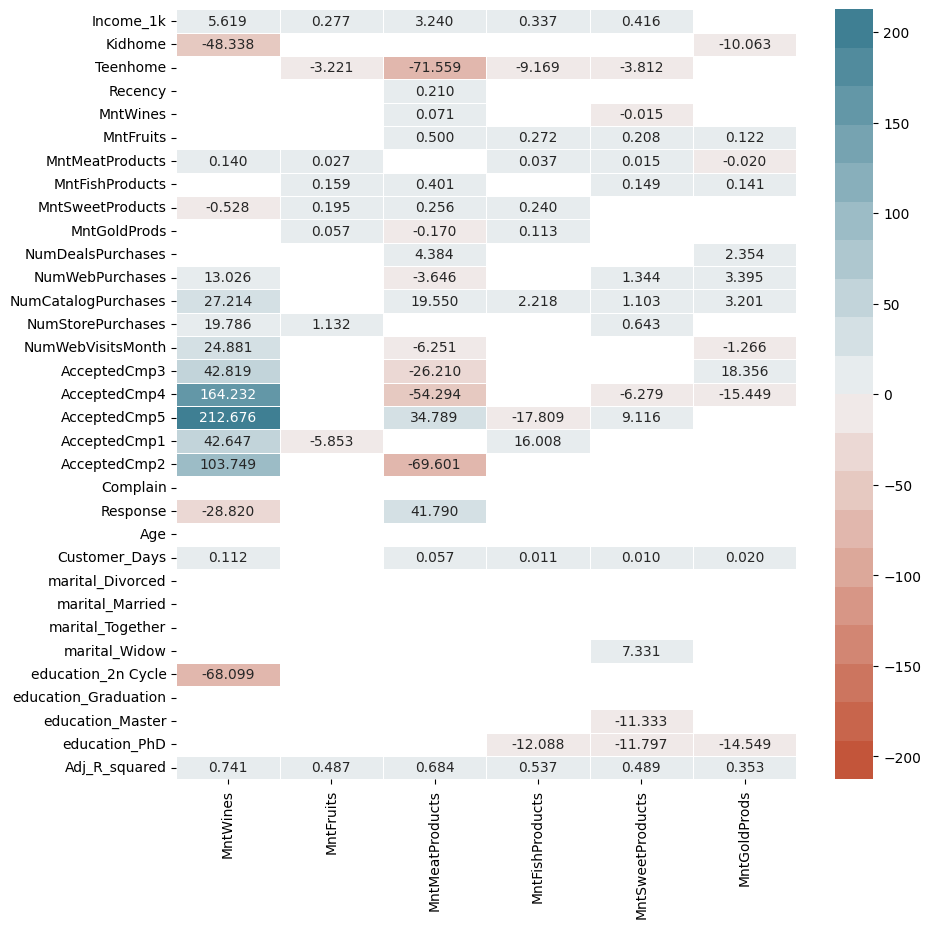

In [7]:
plt.figure(figsize=(10,10))
v = abs(final).max().max()
sns.heatmap(final, annot=True, fmt='.3f', linewidths=0.5, vmin=-v, vmax=v, cmap=sns.diverging_palette(20, 220, sep=1, n=20));

## Logistic Regression predicting Response

In [8]:
# Define dependent and independent variables
y = df['Response']
X = df.filter(X_cols_all).drop(['Response'], axis=1)
#print(X.columns)

logmodel = sm.Logit(y, X)
logresult = logmodel.fit()

Optimization terminated successfully.
         Current function value: 0.273125
         Iterations 8


In [9]:
print(logresult.summary())

                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 2205
Model:                          Logit   Df Residuals:                     2174
Method:                           MLE   Df Model:                           30
Date:                Fri, 01 Dec 2023   Pseudo R-squ.:                  0.3566
Time:                        16:07:56   Log-Likelihood:                -602.24
converged:                       True   LL-Null:                       -935.97
Covariance Type:            nonrobust   LLR p-value:                2.952e-121
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Income_1k               -0.0116      0.008     -1.409      0.159      -0.028       0.005
Kidhome                 -0.1071      0.210     -0.510      0.610      -0.519       0.304
Teenhome    

In [10]:
# Store model results in DF
logfinal = pd.DataFrame()
logfinal['Coefficient'], logfinal['p_value'] = logresult.params, logresult.pvalues

# Filter out statistically insiginficant results
logfinal.loc[(logfinal['p_value'] > 0.05) | (np.isnan(logfinal['p_value'])), 'Coefficient'] = None

logfinal.drop('p_value', axis=1)

,Coefficient
Income_1k,NaN
Kidhome,NaN
Teenhome,-0.852621
Recency,-0.032134
MntWines,NaN
MntFruits,NaN
MntMeatProducts,0.002685
MntFishProducts,NaN
MntSweetProducts,NaN
MntGoldProds,NaN


## Random Forest predicting Response

In [11]:
# Split DFs
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

# Specify RF Classifier
rfc = RandomForestClassifier(random_state=42)

### Hyper Parameter Tuning

In [12]:
np.random.seed(42)

param_random = {
    'n_estimators': list(range(100, 1001, 100)),
    'max_depth': [None] + list(range(3, 20)),
    'max_features': ['sqrt', 'log2', None] + list(np.linspace(0.5,1,5)),
    'max_leaf_nodes': [None] + list(range(10, 501, 10)),
    'bootstrap': [True, False]
    }

# rs = RandomizedSearchCV(rfc, param_random, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
# rs.fit(X_train, y_train)
# print('\nRandomizedSearchCV result:\nBest Score:', rs.best_score_, '\nBest parameters:', rs.best_params_)

RandomizedSearchCV result:<br>
Best Score: 0.8798174736028844<br> 
Best parameters: {'n_estimators': 900, 'max_leaf_nodes': 280, 'max_features': 0.5, 'max_depth': 5, 'bootstrap': False}

### Run Random Forest Classifier

In [13]:
rfc = RandomForestClassifier(random_state = 42,
                             n_estimators = 900,
                             max_leaf_nodes = 280,
                             max_features = 0.5,
                             max_depth = 5,
                             bootstrap = False)

rfc_model = rfc.fit(X_train, y_train)

### Model Accuracy

AUC Score: 0.5986
Accuracy Score: 85.94 %

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       374
           1       0.60      0.22      0.33        67

    accuracy                           0.86       441
   macro avg       0.74      0.60      0.62       441
weighted avg       0.83      0.86      0.83       441



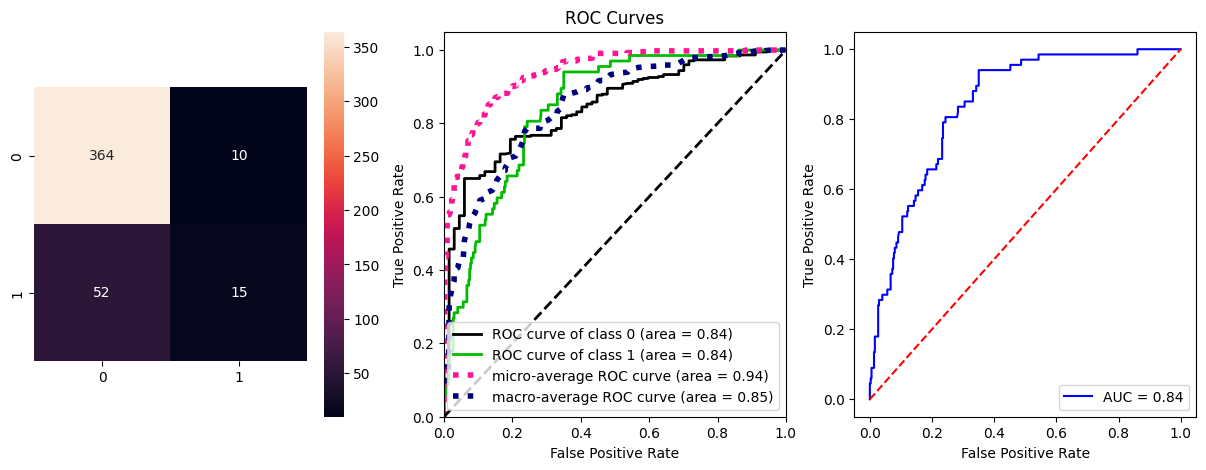

In [25]:
y_pred_X_test = rfc_model.predict(X_test)

print('AUC Score:', round(roc_auc_score(y_test, y_pred_X_test), 4))
print('Accuracy Score:', round(accuracy_score(y_test, y_pred_X_test)*100, 2), '%')
print('\nClassification Report:\n', classification_report(y_test, y_pred_X_test))

# Plots
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_X_test), annot=True, fmt='g', square=True, ax=axs[0])

# ROC
skplt.metrics.plot_roc(y_test, rfc_model.predict_proba(X_test), ax=axs[1])

scores = rfc_model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

axs[2] = plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');


### Feature Importance

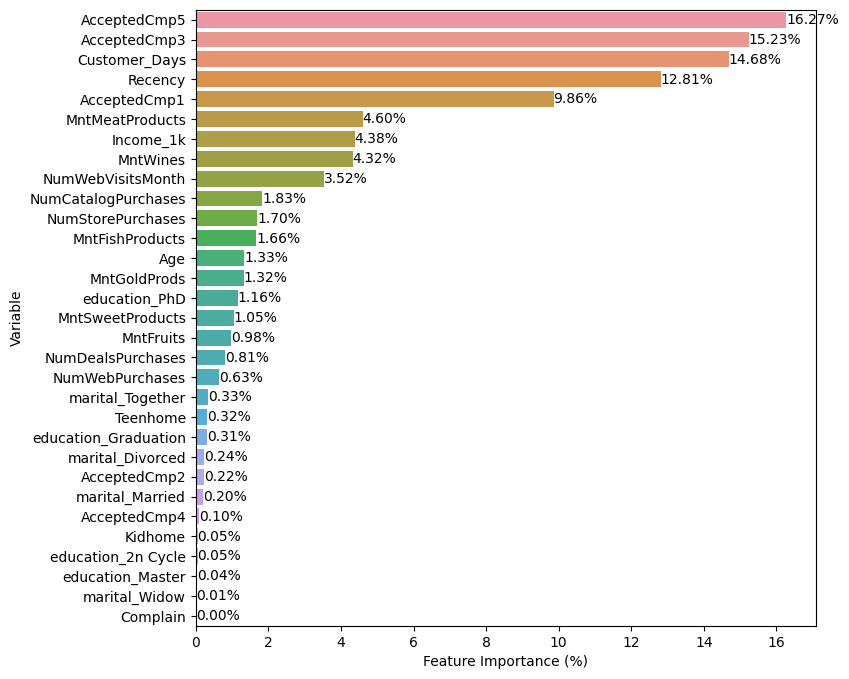

In [ ]:
rfc_imp = pd.DataFrame({
    'Variable': X.columns.to_list(),
    'Feature Importance (%)': np.round(rfc.feature_importances_ * 100, 2)
})

#print('Top 5 Features:\n', rfc_imp.sort_values('Feature Importance (%)', ascending=False).head(5))
rfc_imp.sort_values('Feature Importance (%)', ascending=False, inplace=True)

plt.figure(figsize=(8,8))
ax = sns.barplot(data=rfc_imp, y='Variable', x='Feature Importance (%)')
ax.bar_label(ax.containers[0], fmt='%.2f%%');